In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,
                                     GlobalAveragePooling2D, Input)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from tensorflow.keras.preprocessing import image



In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/ImageClassification/dataset.zip'
extract_path = '/content/brain_tumor_dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction complete!")


Extraction complete!


In [ ]:
from collections import defaultdict

def count_images(data_path):
    class_counts = defaultdict(int)
    for class_dir in os.listdir(data_path):
        class_path = os.path.join(data_path, class_dir)
        if os.path.isdir(class_path):
            num_images = len([
                file for file in os.listdir(class_path)
                if file.lower().endswith(('.jpg', '.jpeg', '.png'))
            ])
            class_counts[class_dir] = num_images
    return class_counts

# Define dataset directories
train_path = '/content/brain_tumor_dataset/Training'
test_path = '/content/brain_tumor_dataset/Testing'

# Get counts
train_counts = count_images(train_path)
test_counts = count_images(test_path)

# Print class counts for both Training and Testing
print("📊 Training Set:")
for cls, count in train_counts.items():
    print(f"{cls}: {count} images")

print("\n📊 Testing Set:")
for cls, count in test_counts.items():
    print(f"{cls}: {count} images")


📊 Training Set:
glioma: 1321 images
pituitary: 1457 images
notumor: 1595 images
meningioma: 1339 images

📊 Testing Set:
glioma: 300 images
pituitary: 300 images
notumor: 405 images
meningioma: 306 images


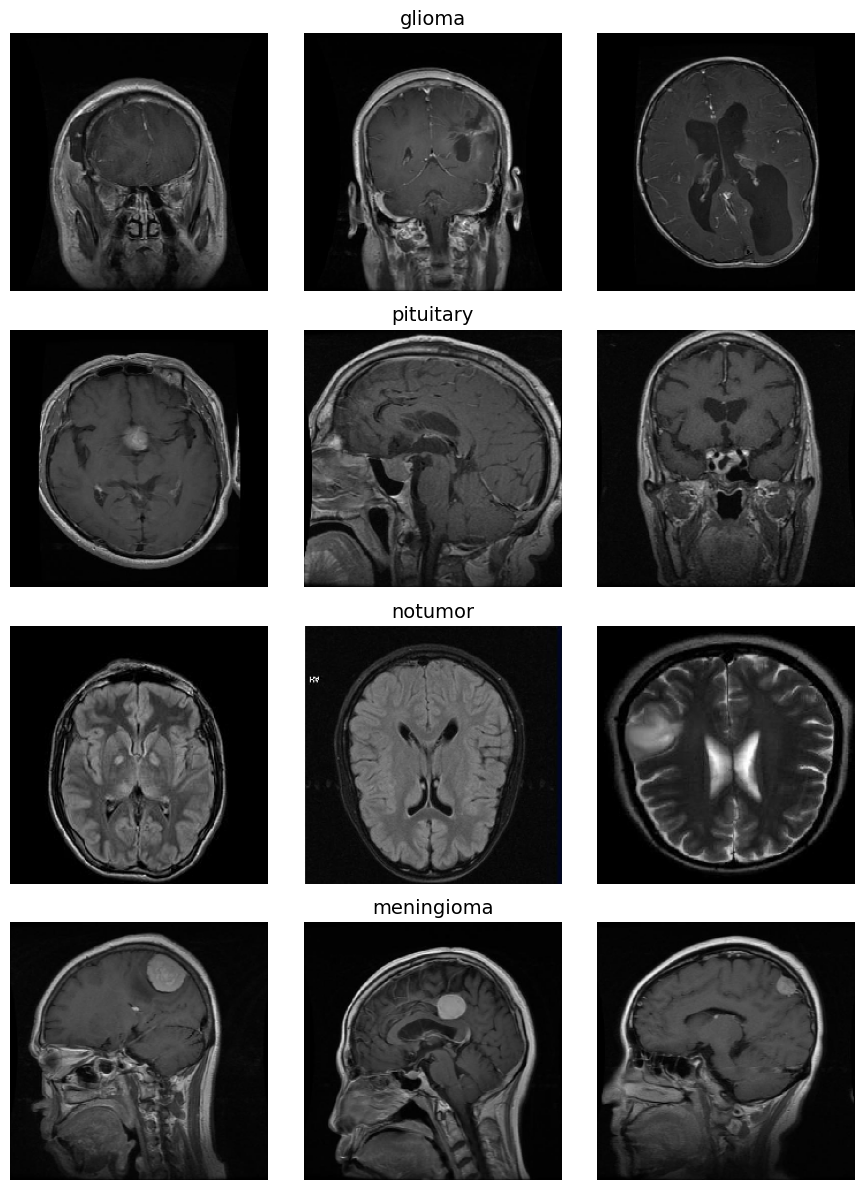

In [ ]:
# Get class names from the train directory
class_names = os.listdir(train_path)

# Create a figure to plot images
fig.suptitle("Sample Images (3 per Class)", y=0.92, fontsize=16)
fig, axes = plt.subplots(len(class_names), 3, figsize=(9, 3 * len(class_names)))

# Iterate over each class to get sample images
for class_idx, cname in enumerate(class_names):
    class_folder = os.path.join(train_path, cname)

    # List all image paths for the current class
    img_paths = [os.path.join(class_folder, fname) for fname in os.listdir(class_folder)]

    # Pick up to 3 images
    for col in range(min(3, len(img_paths))):
        img_path = img_paths[col]

        # Load and preprocess image
        img = image.load_img(img_path, target_size=(224, 224))  # Change to your image size
        img_array = image.img_to_array(img) / 255.0  # Normalize the image

        ax = axes[class_idx, col]
        ax.imshow(img_array)
        ax.axis('off')
        if col == 1:  # Display class name as title for the middle image
            ax.set_title(cname, fontsize=14)

# Adjust layout for readability
plt.tight_layout()
plt.show()


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (128, 128)  # Resize images to this size
BATCH_SIZE = 32

# Image Augmentation and Rescaling for training data
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    validation_split=0.2
)

# Training and Validation Data Generators
train_gen = datagen.flow_from_directory(
    train_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    train_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Testing Data Generator
test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

def build_baseline_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(*IMG_SIZE, 3)),
        MaxPooling2D(2, 2),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),

        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),

        Flatten(),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(4, activation='softmax')  # 4 classes (glioma, meningioma, pituitary, no_tumor)
    ])
    return model

# Compile and summarize the model
baseline_model = build_baseline_model()
baseline_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
baseline_model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,313,156 (12.64 MB)

 Trainable params: 3,313,156 (12.64 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_baseline = baseline_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 35s 223ms/step - accuracy: 0.5390 - loss: 1.0189 - val_accuracy: 0.6941 - val_loss: 0.7996
Epoch 2/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 29s 204ms/step - accuracy: 0.7675 - loss: 0.5754 - val_accuracy: 0.7301 - val_loss: 0.7072
Epoch 3/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 30s 211ms/step - accuracy: 0.8212 - loss: 0.4651 - val_accuracy: 0.7029 - val_loss: 0.8354
Epoch 4/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 30s 213ms/step - accuracy: 0.8286 - loss: 0.4312 - val_accuracy: 0.7458 - val_loss: 0.6740
Epoch 5/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 29s 206ms/step - accuracy: 0.8525 - loss: 0.3635 - val_accuracy: 0.7555 - val_loss: 0.6797
Epoch 6/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 29s 204ms/step - accuracy: 0.8747 - loss: 0.3221 - val_accuracy: 0.7379 - val_loss: 0.7755
Epoch 7/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 30s 208ms/step - accuracy: 0.8735 - loss: 0.3165 - val_accuracy: 0.7651 - val_loss: 0.7236
Epoch 8/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 30s 209ms/step - accuracy: 0.8880 - loss: 0

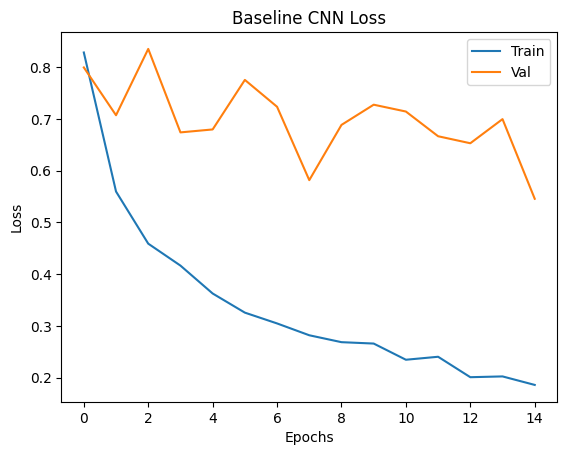

In [ ]:
def plot_loss(history, title):
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Val')
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

plot_loss(history_baseline, "Baseline CNN Loss")


In [ ]:
# Evaluate the model on the test set (after training)
test_loss, test_accuracy = baseline_model.evaluate(test_gen)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.8200 - loss: 0.5778
Test Accuracy: 81.24%


41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step
Baseline Model Accuracy on Test Set: 63.69%


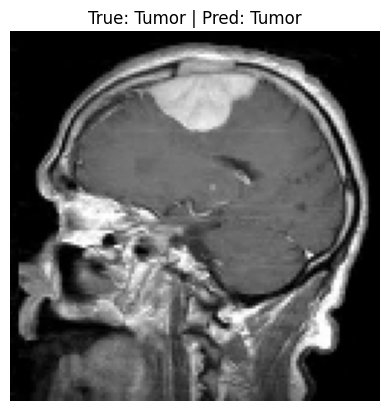

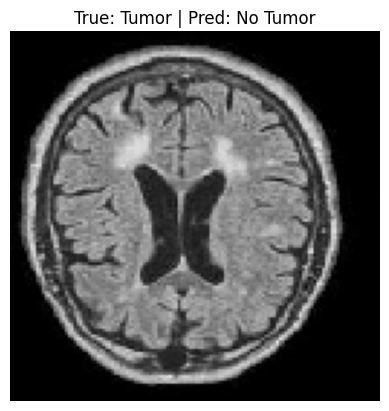

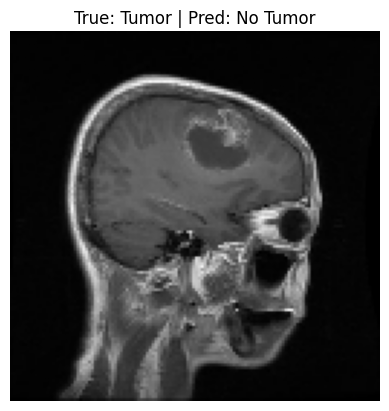

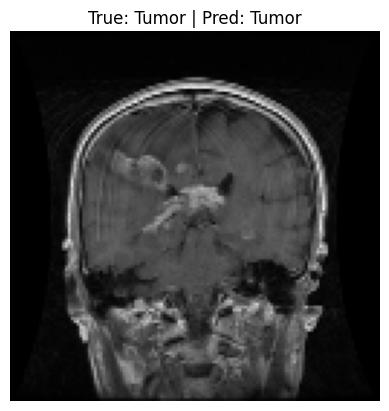

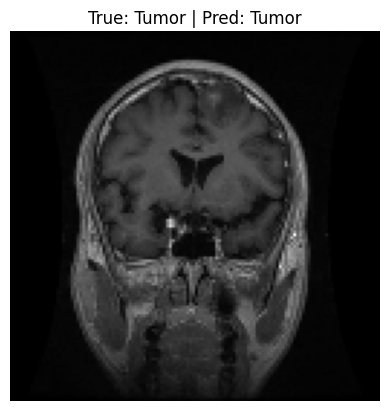

In [ ]:
# Get predictions from the model
test_gen.reset()  # Reset generator to make predictions
preds = baseline_model.predict(test_gen, verbose=1)

# Get predicted class labels
y_pred = np.argmax(preds, axis=1)  # Predicted class indices (0-3)

# Get the true class labels
y_true = test_gen.classes  # Actual class indices (0-3)

# Map the classes to "Tumor" or "No Tumor"
class_mapping = {
    0: "Tumor",  # glioma
    1: "Tumor",  # meningioma
    2: "Tumor",  # pituitary tumor
    3: "No Tumor"  # no tumor
}

# Apply the mapping
y_pred_mapped = [class_mapping[label] for label in y_pred]
y_true_mapped = [class_mapping[label] for label in y_true]

# Calculate accuracy
accuracy = accuracy_score(y_true_mapped, y_pred_mapped)
print(f"Baseline Model Accuracy on Test Set: {accuracy * 100:.2f}%")

# Display sample images with predicted and actual labels
num_samples = 5  # Display 5 samples from the test set
sample_indices = np.random.choice(len(y_true), num_samples, replace=False)

for idx in sample_indices:
    # Load the image and corresponding label
    img_path = test_gen.filepaths[idx]
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img) / 255.0  # Normalize the image

    # Get the predicted and true class names
    predicted_class = y_pred_mapped[idx]
    true_class = y_true_mapped[idx]

    # Display the image and title
    plt.imshow(img_array)
    plt.title(f"True: {true_class} | Pred: {predicted_class}")
    plt.axis('off')
    plt.show()


36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 315ms/step
Classification Report:
              precision    recall  f1-score   support

      glioma       0.22      0.19      0.20       264
  meningioma       0.25      0.22      0.23       267
     notumor       0.29      0.33      0.31       319
   pituitary       0.30      0.33      0.31       291

    accuracy                           0.27      1141
   macro avg       0.26      0.27      0.26      1141
weighted avg       0.27      0.27      0.27      1141



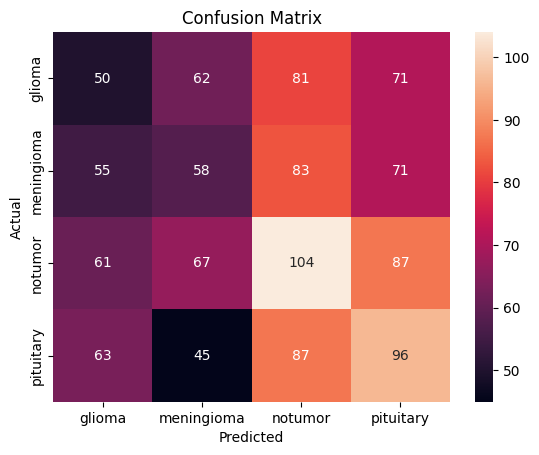

In [ ]:
# Evaluate the model on the validation set
val_gen.reset()
preds = baseline_model.predict(val_gen)
y_pred = np.argmax(preds, axis=1)
y_true = val_gen.classes

# Classification report and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=train_gen.class_indices.keys()))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=train_gen.class_indices.keys(), yticklabels=train_gen.class_indices.keys())
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
def build_deeper_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(*IMG_SIZE, 3)),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.5),

        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.5),

        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.5),

        Conv2D(256, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.5),

        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(4, activation='softmax')
    ])
    return model

deep_model = build_deeper_model()
deep_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
deep_model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │     2,359,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,783,300 (10.62 MB)

 Trainable params: 2,782,340 (10.61 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 49s 269ms/step - accuracy: 0.4839 - loss: 2.3676 - val_accuracy: 0.2550 - val_loss: 2.3773
Epoch 2/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 29s 206ms/step - accuracy: 0.5996 - loss: 0.9902 - val_accuracy: 0.2559 - val_loss: 3.5248
Epoch 3/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 30s 207ms/step - accuracy: 0.6228 - loss: 0.9213 - val_accuracy: 0.2962 - val_loss: 6.2755
Epoch 4/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 31s 216ms/step - accuracy: 0.6794 - loss: 0.8381 - val_accuracy: 0.3374 - val_loss: 8.8644
Epoch 5/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 30s 207ms/step - accuracy: 0.7147 - loss: 0.7404 - val_accuracy: 0.2954 - val_loss: 7.3508
Epoch 6/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 29s 206ms/step - accuracy: 0.7237 - loss: 0.6918 - val_accuracy: 0.4584 - val_loss: 1.8488
Epoch 7/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 35s 243ms/step - accuracy: 0.7424 - loss: 0.6524 - val_accuracy: 0.5495 - val_loss: 1.3141
Epoch 8/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 30s 207ms/step - accuracy: 0.7789 - loss: 0

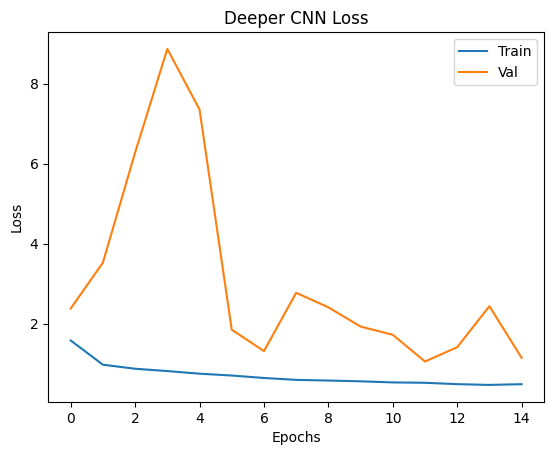

In [ ]:
history_deep = deep_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15
)

plot_loss(history_deep, "Deeper CNN Loss")


41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step
Deeper Model Accuracy on Test Set: 52.10%


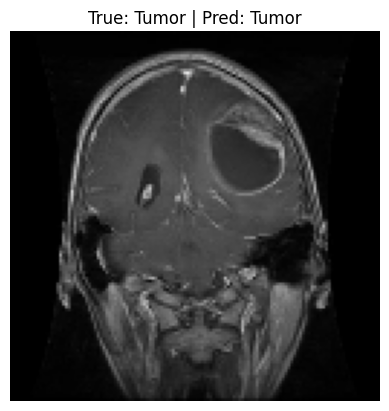

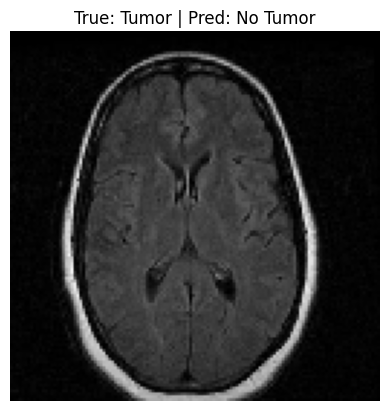

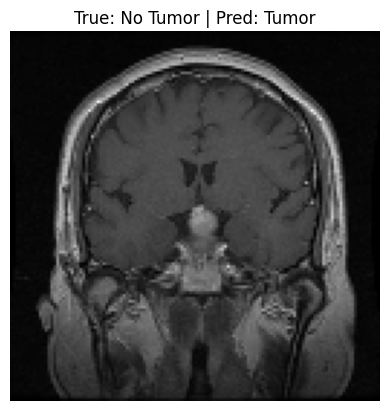

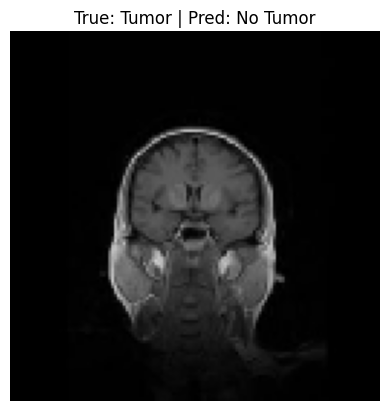

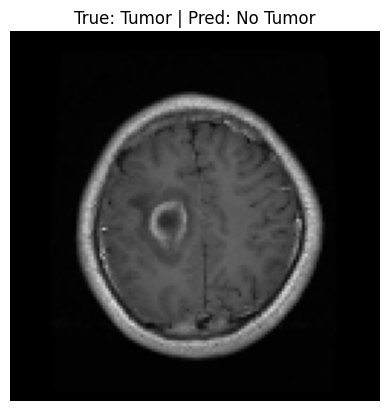

In [ ]:

# Get predictions from the deeper model
test_gen.reset()
preds = deep_model.predict(test_gen, verbose=1)

# Get predicted class labels
y_pred = np.argmax(preds, axis=1)

# Get the true class labels
y_true = test_gen.classes

# Map classes to "Tumor" or "No Tumor"
class_mapping = {
    0: "Tumor",
    1: "Tumor",
    2: "Tumor",
    3: "No Tumor"
}

y_pred_mapped = [class_mapping[label] for label in y_pred]
y_true_mapped = [class_mapping[label] for label in y_true]

# Evaluate accuracy
accuracy = accuracy_score(y_true_mapped, y_pred_mapped)
print(f"Deeper Model Accuracy on Test Set: {accuracy * 100:.2f}%")

# Display sample image predictions
num_samples = 5
sample_indices = np.random.choice(len(y_true), num_samples, replace=False)

for idx in sample_indices:
    img_path = test_gen.filepaths[idx]
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img) / 255.0

    predicted_class = y_pred_mapped[idx]
    true_class = y_true_mapped[idx]

    plt.imshow(img_array)
    plt.title(f"True: {true_class} | Pred: {predicted_class}")
    plt.axis('off')
    plt.show()

36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 193ms/step
Classification Report:
              precision    recall  f1-score   support

      glioma       0.23      0.15      0.18       264
  meningioma       0.26      0.10      0.15       267
     notumor       0.31      0.23      0.26       319
   pituitary       0.25      0.54      0.34       291

    accuracy                           0.26      1141
   macro avg       0.26      0.25      0.23      1141
weighted avg       0.26      0.26      0.24      1141



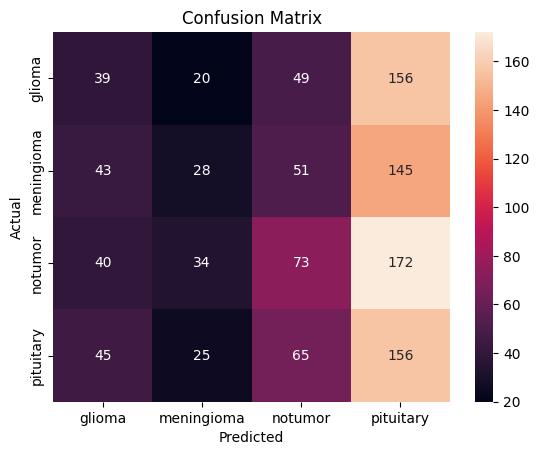

In [ ]:
# Evaluate the model on the validation set
val_gen.reset()
preds = deep_model.predict(val_gen)
y_pred = np.argmax(preds, axis=1)
y_true = val_gen.classes

# Classification report and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=train_gen.class_indices.keys()))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=train_gen.class_indices.keys(), yticklabels=train_gen.class_indices.keys())
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
# Evaluate the model on the test set (after training)
test_loss, test_accuracy = baseline_model.evaluate(test_gen)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8227 - loss: 0.6225
Test Accuracy: 81.24%


In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model to prevent them from being trained
for layer in base_model.layers:
    layer.trainable = False

# Add new fully connected layers for your classification task
x = Flatten()(base_model.output)  # Flatten the output of the base model
x = Dense(512, activation='relu')(x)  # New fully connected layer
x = Dropout(0.5)(x)  # Dropout layer for regularization
x = Dense(4, activation='softmax')(x)  # Final output layer (4 classes for tumor types)

# Create the new model
model = Model(inputs=base_model.input, outputs=x)

# Summarize the model to check its architecture
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,562,308 (105.14 MB)

 Trainable params: 12,847,620 (49.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 20% of training data will be used for validation
)

train_gen_VGG = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_gen_VGG = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)
test_datagen = ImageDataGenerator(rescale=1./255)

test_gen_VGG = test_datagen.flow_from_directory(
    '/content/brain_tumor_dataset/Testing',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Important for matching predictions with true labels
)

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [ ]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history_vgg = model.fit(
    train_gen_VGG,
    validation_data=val_gen_VGG,
    epochs=5
)


Epoch 1/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 92s 626ms/step - accuracy: 0.7425 - loss: 0.6628 - val_accuracy: 0.7125 - val_loss: 0.7182
Epoch 2/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 77s 541ms/step - accuracy: 0.8171 - loss: 0.4795 - val_accuracy: 0.7388 - val_loss: 0.6882
Epoch 3/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 77s 538ms/step - accuracy: 0.8419 - loss: 0.4365 - val_accuracy: 0.8063 - val_loss: 0.5438
Epoch 4/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 76s 531ms/step - accuracy: 0.8407 - loss: 0.3850 - val_accuracy: 0.8107 - val_loss: 0.4916
Epoch 5/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 82s 577ms/step - accuracy: 0.8586 - loss: 0.3851 - val_accuracy: 0.8063 - val_loss: 0.5083


In [ ]:
# Evaluate the fine-tuned model
test_loss, test_acc = model.evaluate(test_gen_VGG)
print(f"Fine-Tuned Model Accuracy on Test Set: {test_acc * 100:.2f}%")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 167ms/step - accuracy: 0.7628 - loss: 0.5615
Fine-Tuned Model Accuracy on Test Set: 83.52%


In [ ]:
# Display 5 random predictions
num_samples = 5
sample_indices = np.random.choice(len(y_true), num_samples, replace=False)

for idx in sample_indices:
    img_path = test_gen.filepaths[idx]
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0

    # True and predicted labels
    true_label = class_labels[y_true[idx]]
    pred_label = class_labels[y_pred[idx]]

    # Show image
    plt.imshow(img_array)
    plt.title(f"True: {true_label} | Predicted: {pred_label}", fontsize=12)
    plt.axis('off')
    plt.show()

41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 183ms/step
Fine-Tuned Model Accuracy on Test Set: 83.52%


1. Baseline vs. Deeper Model Performance

In [ ]:

# Evaluate baseline model
baseline_loss, baseline_accuracy = baseline_model.evaluate(test_gen)
baseline_preds = baseline_model.predict(test_gen)
baseline_y_pred = np.argmax(baseline_preds, axis=1)
baseline_y_true = test_gen.classes

baseline_precision = precision_score(baseline_y_true, baseline_y_pred, average='weighted')
baseline_recall = recall_score(baseline_y_true, baseline_y_pred, average='weighted')
baseline_f1 = f1_score(baseline_y_true, baseline_y_pred, average='weighted')

# Evaluate deeper model
deeper_loss, deeper_accuracy = deep_model.evaluate(test_gen)
deeper_preds = deep_model.predict(test_gen)
deeper_y_pred = np.argmax(deeper_preds, axis=1)
deeper_y_true = test_gen.classes

deeper_precision = precision_score(deeper_y_true, deeper_y_pred, average='weighted')
deeper_recall = recall_score(deeper_y_true, deeper_y_pred, average='weighted')
deeper_f1 = f1_score(deeper_y_true, deeper_y_pred, average='weighted')

# Display results
print(f"Baseline Model - Accuracy: {baseline_accuracy:.4f}, Loss: {baseline_loss:.4f}")
print(f"Deeper Model - Accuracy: {deeper_accuracy:.4f}, Loss: {deeper_loss:.4f}")
print(f"Baseline Model - Precision: {baseline_precision:.4f}, Recall: {baseline_recall:.4f}, F1: {baseline_f1:.4f}")
print(f"Deeper Model - Precision: {deeper_precision:.4f}, Recall: {deeper_recall:.4f}, F1: {deeper_f1:.4f}")


41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.8006 - loss: 0.6650
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.6851 - loss: 0.9158
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step
Baseline Model - Accuracy: 0.8124, Loss: 0.6190
Deeper Model - Accuracy: 0.6682, Loss: 0.9456
Baseline Model - Precision: 0.2556, Recall: 0.2624, F1: 0.2547
Deeper Model - Precision: 0.2835, Recall: 0.2532, F1: 0.2272


2. Computational Efficiency


In [ ]:
import time

# Track training time for baseline model
start_time_baseline = time.time()
baseline_history = baseline_model.fit(train_gen, validation_data=val_gen, epochs=10)
end_time_baseline = time.time()
baseline_training_time = end_time_baseline - start_time_baseline

# Track training time for deeper model
start_time_deeper = time.time()
deep_history = deep_model.fit(train_gen, validation_data=val_gen, epochs=10)
end_time_deeper = time.time()
deeper_training_time = end_time_deeper - start_time_deeper

print(f"Baseline Model Training Time: {baseline_training_time:.2f} seconds")
print(f"Deeper Model Training Time: {deeper_training_time:.2f} seconds")


Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 31s 216ms/step - accuracy: 0.9291 - loss: 0.1813 - val_accuracy: 0.8046 - val_loss: 0.6353
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 32s 226ms/step - accuracy: 0.9412 - loss: 0.1583 - val_accuracy: 0.8177 - val_loss: 0.6467
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 44s 250ms/step - accuracy: 0.9367 - loss: 0.1787 - val_accuracy: 0.8282 - val_loss: 0.6171
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 29s 205ms/step - accuracy: 0.9516 - loss: 0.1348 - val_accuracy: 0.8273 - val_loss: 0.6552
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 30s 207ms/step - accuracy: 0.9489 - loss: 0.1333 - val_accuracy: 0.8238 - val_loss: 0.6644
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 34s 240ms/step - accuracy: 0.9498 - loss: 0.1338 - val_accuracy: 0.8449 - val_loss: 0.5871
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 29s 205ms/step - accuracy: 0.9488 - loss: 0.1263 - val_accuracy: 0.8195 - val_loss: 0.6743
Epoch 8/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 37s 259ms/step - accuracy: 0.9532 - loss: 0

3. Optimizer Analysis: SGD vs Adam

In [ ]:
# Compile model with SGD optimizer
deep_model_sgd = build_deeper_model()
deep_model_sgd.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the deeper model with SGD
history_sgd = deep_model_sgd.fit(train_gen, validation_data=val_gen, epochs=10)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 43s 245ms/step - accuracy: 0.4273 - loss: 1.8800 - val_accuracy: 0.2550 - val_loss: 4.8330
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 30s 210ms/step - accuracy: 0.5838 - loss: 1.0037 - val_accuracy: 0.2550 - val_loss: 5.8875
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 29s 203ms/step - accuracy: 0.6180 - loss: 0.9058 - val_accuracy: 0.2559 - val_loss: 5.1078
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 29s 203ms/step - accuracy: 0.6599 - loss: 0.8332 - val_accuracy: 0.2568 - val_loss: 5.5963
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 29s 203ms/step - accuracy: 0.6791 - loss: 0.7891 - val_accuracy: 0.2550 - val_loss: 5.0243
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 29s 204ms/step - accuracy: 0.6762 - loss: 0.7899 - val_accuracy: 0.2585 - val_loss: 4.1336
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 31s 214ms/step - accuracy: 0.6994 - loss: 0.7248 - val_accuracy: 0.2550 - val_loss: 6.2484
Epoch 8/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 29s 205ms/step - accuracy: 0.7318 - loss: 0

In [ ]:
# Compile model with Adam optimizer
deep_model_adam = build_deeper_model()
deep_model_adam.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the deeper model with Adam
history_adam = deep_model_adam.fit(train_gen, validation_data=val_gen, epochs=10)


Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 50s 280ms/step - accuracy: 0.4658 - loss: 2.3381 - val_accuracy: 0.2550 - val_loss: 4.4851
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 29s 206ms/step - accuracy: 0.6135 - loss: 0.9890 - val_accuracy: 0.2550 - val_loss: 4.1282
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 29s 204ms/step - accuracy: 0.6613 - loss: 0.8935 - val_accuracy: 0.2866 - val_loss: 2.9759
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 30s 210ms/step - accuracy: 0.6710 - loss: 0.8189 - val_accuracy: 0.3453 - val_loss: 3.2590
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 41s 210ms/step - accuracy: 0.6944 - loss: 0.7515 - val_accuracy: 0.2945 - val_loss: 8.8833
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 30s 208ms/step - accuracy: 0.7364 - loss: 0.7099 - val_accuracy: 0.5259 - val_loss: 2.6225
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 29s 204ms/step - accuracy: 0.7280 - loss: 0.6630 - val_accuracy: 0.5110 - val_loss: 3.1610
Epoch 8/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 41s 206ms/step - accuracy: 0.7543 - loss: 0

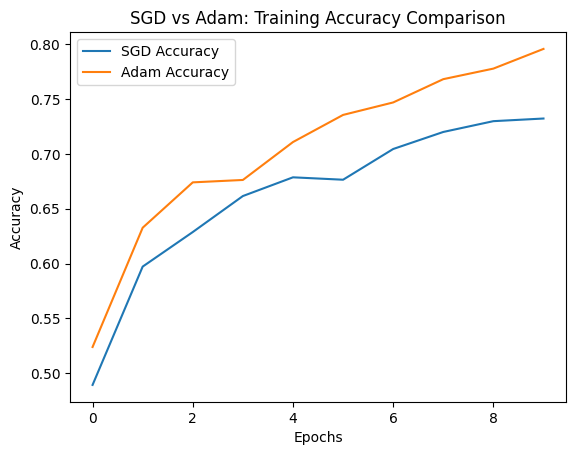

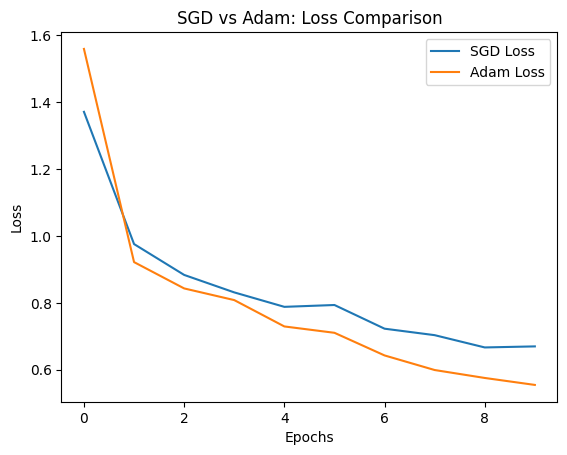

In [ ]:
plt.plot(history_sgd.history['accuracy'], label='SGD Accuracy')
plt.plot(history_adam.history['accuracy'], label='Adam Accuracy')
plt.legend()
plt.title('SGD vs Adam: Training Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

plt.plot(history_sgd.history['loss'], label='SGD Loss')
plt.plot(history_adam.history['loss'], label='Adam Loss')
plt.legend()
plt.title('SGD vs Adam: Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()
